In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

from os import listdir
from os.path import isfile, join
import os.path
import random
import scipy.special as sp

from edward.models import Poisson,Gamma

plt.style.use('ggplot')

In [2]:
X = np.loadtxt('./pre_processed_data/bibtex/Y_train.txt',delimiter=',')
train_mask = np.loadtxt('./pre_processed_data/bibtex/y_train_mask.txt')
y = X*train_mask
tot = 101
ndcg = []

In [3]:
def ndcg_score(result):
        
    ndcg.append(0)
    for i in range(0,users):
        sort_index = np.argsort(result[i])[::-1]
        score = 0
        norm = 0
        count = 1
        
        for j in range(0,items):
                if train_mask[i,sort_index[j]] == 0 and X[i,sort_index[j]] == 1:
                    count += 1
                    norm += 1.0/np.log2(count)
                    score += 1.0/np.log2(j+2)
        if norm != 0:
            ndcg[-1] += score/norm
        else:
            ndcg[-1] += 0
    ndcg[-1] /= users
    print("Score is %f " % ndcg[-1])

In [4]:
def non_zero_entries(mat):
    indices = []
    for i in range(0,mat.shape[0]):
        for j in range(0,mat.shape[1]):
            if mat[i,j] > 0:
                indices.append((i,j))
    return indices

In [5]:
def check():
    q_theta = Gamma(gam_shp,gam_rte)
    q_beta = Gamma(lam_shp,lam_rte)
    sess = tf.InteractiveSession()
    init = tf.global_variables_initializer()
    init.run()
    no_sample = 100
    beta_sample = q_beta.sample(no_sample).eval()
    theta_sample = q_theta.sample(no_sample).eval()
    result = np.zeros([users,items])
    for i in range(0,no_sample):
        result = np.add(result,np.matmul(theta_sample[i],np.transpose(beta_sample[i])))
    result /= no_sample
    #mae(t,result)
    ndcg_score(result)

In [6]:
K = 5
users = X.shape[0]
items = X.shape[1]
a = a_c = c = c_c = 0.3
b_c = d_c = 1.0      

In [7]:
kappa_shp =  np.random.uniform(low=0.1,size=users)
kappa_rte = np.random.uniform(low=0.1,size=users)
tau_shp = np.random.uniform(low=0.1,size=items)
tau_rte = np.random.uniform(low=0.1,size=items)
phi = np.zeros([users,items,K])
gam_shp = np.random.uniform(low=0.1,size=[users,K])
gam_rte = np.random.uniform(low=0.1,size=[users,K])
lam_shp = np.random.uniform(low=0.1,size=[items,K])
lam_rte = np.random.uniform(low=0.1,size=[items,K])
non_zero_indices = non_zero_entries(y)    

In [8]:
print(len(non_zero_indices))

6393


In [9]:
for u in range(0,users):
    kappa_shp[u] = a_c + K*a
for i in range(0,items):
    tau_shp[i] = c_c + K*c

    
for ite in range(0,tot):

    if ite%1==0:
        print(ite)
        
    
    for ui in non_zero_indices:
        u = ui[0]
        i = ui[1]
        phi[u,i,:]= np.exp(sp.digamma(gam_shp[u,:])-np.log(gam_rte[u,:])+sp.digamma(lam_shp[i,:])-np.log(lam_rte[i,:]))
        norm = np.sum(phi[u,i,:])
        phi[u,i,:] = phi[u,i,:]/norm
    
    for u in range(0,users):
        for k in range(0,K):
            gam_shp[u,k] = a + np.inner(y[u,:],phi[u,:,k])
            gam_rte[u,k] = (kappa_shp[u]/kappa_rte[u]) + np.sum(lam_shp[:,k]/lam_rte[:,k])
        kappa_rte[u] = (a_c/b_c) + np.sum(gam_shp[u,:]/gam_rte[u,:])
    
    for i in range(0,items):
        for k in range(0,K):
            lam_shp[i,k] = c + np.inner(y[:,i],phi[:,i,k])
            lam_rte[i,k] = (tau_shp[i]/tau_rte[i]) + np.sum(gam_shp[:,k]/gam_rte[:,k])
        tau_rte[i] = (c_c/d_c) + np.sum(lam_shp[i,:]/lam_rte[i,:])
    
    if ite%10 == 0:
        check()

0
Score is 0.204994 
1
2
3
4
5
6
7
8
9
10
Score is 0.202683 
11
12
13
14
15
16
17
18
19
20
Score is 0.203166 
21
22
23
24
25
26
27
28
29
30
Score is 0.201085 
31
32
33
34
35
36
37
38
39
40
Score is 0.202155 
41
42
43
44
45
46
47
48
49
50
Score is 0.201998 
51
52
53
54
55
56
57
58
59
60
Score is 0.203281 
61
62
63
64
65
66
67
68
69
70
Score is 0.202994 
71
72
73
74
75
76
77
78
79
80
Score is 0.203192 
81
82
83
84
85
86
87
88
89
90
Score is 0.203073 
91
92
93
94
95
96
97
98
99
100
Score is 0.202508 


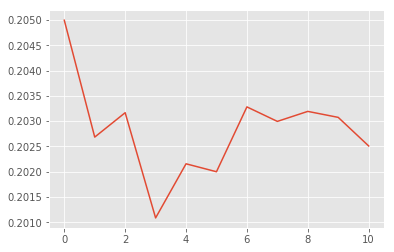

In [10]:
plt.plot(ndcg)
plt.show()
#np.savetxt("mae_s_y_k20.txt",mae_val)